In [45]:
import os
import random
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Lambda, concatenate, multiply, Conv2D, Flatten, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.layers import Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import mse, binary_crossentropy

pd.options.display.float_format = '{:.4f}'.format

In [4]:
class VariationalAutoencoder():
    
    def __init__(self, latent_dim = 5):
        self.latent_dim = latent_dim
    
    
    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]

        epsilon = K.random_normal(shape =(batch, dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    
    def _variational_autoencoder(self, orignal_dim):
        
        orignal_dim = int(orignal_dim[0])
        inputs = Input(shape= orignal_dim, name = 'encoder_input')
        x = Dense(64, activation = 'relu', kernel_initializer= 'he_uniform')(inputs)
        x = Dense(128, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        x = Dense(64, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        x = Dense(32, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        x = Dense(30, activation = 'relu', kernel_initializer= 'he_uniform')(x)

        x = Dense(self.latent_dim, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        z_mean = Dense(self.latent_dim, activation = None, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, activation = None, name='z_log_var'
                          ,kernel_initializer = initializers.glorot_normal())(x)
        z = Lambda(self._sampling, output_shape = (self.latent_dim,), name ='z')([z_mean, z_log_var])

        encoder = Model(inputs, [z_mean, z_log_var, z], name ='encoder')

        latent_input = Input(shape=(self.latent_dim,), name = 'z_sampling')
        x = Dense(30, activation = 'relu', kernel_initializer= 'he_uniform')(latent_input)
        x = Dense(32, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        x = Dense(64, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        x = Dense(128, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        x = Dense(64, activation = 'relu', kernel_initializer= 'he_uniform')(x)
        x = Dense(orignal_dim, activation = None, kernel_initializer= None)(x)
        
        decoder = Model(latent_input, x, name ='decoder')
        output = decoder(encoder(inputs)[2])

        def vae_loss():
            model_input = K.flatten(inputs)
            model_output = K.flatten(output)

            recon_loss= mse(model_input, model_output)
            # recon_loss = binary_crossentropy(model_input, model_output)
            # recon_loss *= self.input_shape[0]
            kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

            return K.mean(recon_loss + kl_loss)

        vae = Model(inputs, output, name='vae')
        vae.add_loss(vae_loss())

        return vae, encoder, decoder
    
    
    def fit(self, x_data, y_data):
        x_data = x_data.values
        y_data = y_data.values
        
        input_shape = x_data.shape[1:]
        
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss', verbose=1, patience=30, mode='min', restore_best_weights=True)
        
        self.model, self.encoder, self.decoder = self._variational_autoencoder(input_shape)
        
        # adam = Adam(0.0001)
        adadelta = tf.keras.optimizers.Adadelta(learning_rate=1., rho=0.95, epsilon=1e-07, name='Adadelta')
        self.model.compile(optimizer=adadelta, loss=None)
        self.model.fit(x= x_train, y= None,
                       validation_data=(x_test, None),
                       callbacks = [early_stopping], 
                       epochs=1000, batch_size=128, verbose=1)

In [38]:
def visualize_anomaly(error_df, threshold = None):
    
    if threshold is None:
        threshold = error_df[error_df['Class'] == 1].y_pred.quantile(q = 0.5) # 95 % higher
        print('Generated threshold : {}'.format(threshold))
        
    fig, ax = plt.subplots(figsize = (10,6))

    for name, group in error_df.groupby('Class'):
        ax.plot(group.index, group['y_pred'], marker = 'o', linestyle = '', alpha = 0.6, 
                label = "Fraud" if name == 1 else "Normal",
                color = 'r' if name == 1 else 'royalblue')

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], 
              colors = 'r', zorder = 100, label = 'Threshold')
    ax.legend()


def confusion_matrix_report(true, pred):
    [tn, fp, fn, tp] = confusion_matrix(true, pred).ravel()
    precision = tp/(fp + tp)
    recall = tp/(fn + tp)
    print(f"\t\tT\tF")
    print(f"\t1 [{tp:5d}, {fn:5d}]")
    print(f"\t0 [{fp:5d}, {tn:5d}]")
    print(f"accuracy : \t{ (tp+tn)/(tn + fp + fn + tp) :2.5f}")
    print(f"precision : \t{precision:2.5f}")
    print(f"recall : \t{recall:2.5f}")
    print(f"f1score : \t{(2*recall*precision)/(recall+precision):2.5f}")
    
    
def shuffle(x, y):
    idx = list(range(y_resample.shape[0]))
    random.shuffle(idx)
    return x[idx], y[idx]

In [10]:
dataset = pd.read_csv(os.path.join("/home/gruds/projects/chan/pico/dataset/credit_card","preprocessed.csv"), index_col = 0)

In [11]:
normalize =True

In [12]:
columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
           'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
           'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Time',
           'Class']
dataset = dataset[columns]

In [15]:
if normalize:
    is_fraud = dataset.Class.values.copy()

    scaler = StandardScaler() # RobustScaler # MinMaxScaler # StandardScaler

    transformed = dataset.drop("Class",axis =1)
    columns = transformed.columns
    transformed = scaler.fit_transform(transformed)

    del dataset
    dataset = pd.DataFrame(data=transformed, columns=columns)
    dataset = dataset.assign(Class = is_fraud)

In [16]:
x = dataset.drop('Class', axis =1)
y = dataset.Class

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
Counter(y_train)

Counter({0: 227430, 1: 393})

In [19]:
variational_autoencoder = VariationalAutoencoder(8)

In [21]:
x_normal = x_train[y_train==0]
y_normal = y_train[y_train==0]

In [22]:
variational_autoencoder.fit(x_normal, y_normal)

Train on 181944 samples, validate on 45486 samples
Epoch 1/1000
181944/181944 [==============================] - 14s 76us/sample - loss: 0.9673 - val_loss: 0.8404
Epoch 2/1000
181944/181944 [==============================] - 12s 67us/sample - loss: 0.7636 - val_loss: 0.6812
Epoch 3/1000
181944/181944 [==============================] - 12s 68us/sample - loss: 0.6213 - val_loss: 0.5696
Epoch 4/1000
181944/181944 [==============================] - 12s 68us/sample - loss: 0.5298 - val_loss: 0.4994
Epoch 5/1000
181944/181944 [==============================] - 12s 67us/sample - loss: 0.4569 - val_loss: 0.4455
Epoch 6/1000
181944/181944 [==============================] - 12s 67us/sample - loss: 0.4066 - val_loss: 0.3790
Epoch 7/1000
181944/181944 [==============================] - 12s 68us/sample - loss: 0.3642 - val_loss: 0.3516
Epoch 8/1000
181944/181944 [==============================] - 12s 68us/sample - loss: 0.3354 - val_loss: 0.3238
Epoch 9/1000
181944/181944 [=========================

In [23]:
y_pred = variational_autoencoder.model.predict(x_test, verbose=1)

56956/56956 [==============================] - 5s 79us/sample


In [30]:
recon_error = []
for p,t in zip(y_pred, x_test.values.astype('float32')):
    recon_error.append( np.mean((p-t)**2) )

In [32]:
# recon_error

In [35]:
error_df = pd.DataFrame({
                "y_pred" : recon_error,
                "Class" : y_test,
            })

In [54]:
confusion_matrix_report(error_df.Class, error_df.y_pred > 1.9)

		T	F
	1 [   45,    50]
	0 [   91, 56770]
accuracy : 	0.99752
precision : 	0.33088
recall : 	0.47368
f1score : 	0.38961


Generated threshold : 1.7908118963241577


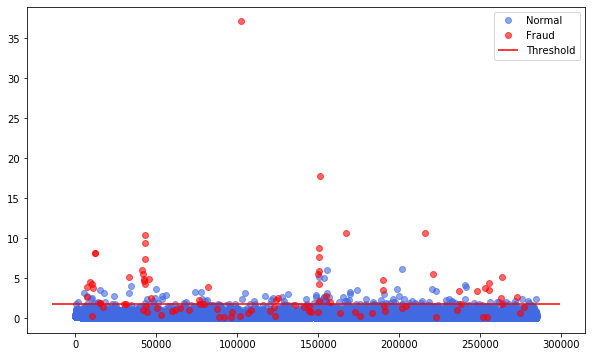

In [43]:
visualize_anomaly(error_df)